# Introducción

El ITAM y muchos de sus miembros tenemos residencia en la Ciudad de México. Esta metrópolis es una de las más contaminadas en el continente y en el mundo. A causa de la pandemia, una gran cantidad de la población pasamos mucho de nuestro tiempo encerrados en espacios cerrados, típicamente nuestras viviendas. Queremos saber cómo influyen los factores atmosféricos y la contaminación de la Ciudad en la contaminación de un espacio cerrado.

Hemos almacenado los datos de este sensor desde Febrero 2021 tratando de mantenerlos en un área común que no tiene ventilación directa para evitar perturbaciones en las lecturas y que sea influído directamente por la contaminación exterior, así como de otras fuentes de emisión (cocina). 

Es importante destacar que este sensor no detecta contaminantes primarios, tales como: óxidos de nitrógeno (NOx), dióxido de carbono (CO2), monóxido de carbono (CO), ozono (O3), más bien mide los compuestos orgánicos volátiles, conocidos por el acrónimo anglosajón VOCs. Los VOCs típicamente son muchos de los olores que percibimos, los cuales son disoluciones de compuestos en el aire.

Estos compuestos orgánicos volátiles se han comprobado como nocivos a la salud y posibles cancerígenos, lo cual nos despertó el interés. Ejemplos de estos compuestos orgánicos son: el humo del cigarro, humo causado por cocinar alimentos, la utilización de agentes de limpieza (cloro y basados en amoniaco) y fuentes volátiles varias (como solventes, pinturas, quitaesmaltes), entre otros.

## Fuentes de Datos Prospecto

Tenemos los siguientes de fuentes de datos:

* Sensor Bosch BME680: contamos aproximadamente con casi 1.3 millones de registros con lecturas del sensor cada 3 segundos.

* Datos Abiertos de la Calidad del Aire del Gobierno de la Ciudad de México: datos por hora de las estaciones de monitoreo del Gobierno. 

* Datos de otras estaciones meteorológicas de la Ciudad.

### Problemáticas

* Datos del Gobierno de la Ciudad de México: estos datos no están siendo actualizados de manera cotidiana, por lo que en ocasiones tienen atrasos en publicar la información actual. Ejemplo, al 31 de marzo no habían subido actualizaciones desde el 28 de enero. Pensamos contrarrestarlo utilizando la fuente de datos federal (Sinaica) que se encuentra en la bibliografía.

* Datos meteorológicos de terceros: Pudieran ser fuentes propietarias que serían de difícil acceso o hubiera que utilizar minería de datos (webscraping). Continuaremos buscando fuentes abiertas y confiables.

* Precisión y manipulación de los datos de nuestras fuentes de datos.

* Estabilidad y precisión de la toma de registros en el sensor. Pudiéramos tener interrupciones del suministro eléctrico que no permitieran obtener ciertas lecturas.

## Variables 

Las siguientes son las variables obtenidas por el sensor Bosch BME680:

* Temperatura: variable numérica en grados Celsius (C) con una resolución de $0.01C$ y una precisión de $\pm 0.5C$.

* Presión: variable numérica en hectopascales (hPa) con una resolución de $0.18~hPa$ y una precisión de $\pm 0.12~hPA$.

* Humedad: variable numérica en porcentaje de humedad relativa (%rH) con una resolución de $0.008~\%rH$ y una precisión de $\pm 3\%rH$.

* Resistencia del Gas: variable numérica de la resistencia eléctrica opuesta al elemento sensible del sensor medida en Ohms.

* IAQ: variable numérica medida en el índice de calidad del aire americano en interior (IAQI, aunque utilizaremos la nomenclatura IAQ) con una resolución de $1~ IAQ$. La precisión del sensor variable que no excede 5% se guarda en una variable independiente. 

* Precisión del sensor: variable categórica ordinal con valores en el rango de [0,3]:

    * 0: periodo de estabilización o no operativo.
    
    * 1-2: periodo operativo.
    
    * 3: precisión máxima y operación óptima.

* Fecha y hora: variable numérica basado en UNIX/POSIX epoch que denota el tiempo desde el 01/01/1970 00:00:00.0 UTC. El tiempo está sincronizado por NTP al Centro Nacional de Metrología de México (Hora Oficial del País). 

## Análisis Exploratorio Inicial

Hemos empezado a realizar un análisis exploratorio de los datos y recopilación de los datos de fuentes externas. A continuación mostramos algunas gráficas de las lecturas del sensor.

In [1]:
import os, gzip, json, re
from plotnine import *
import pandas as pd
from IPython.display import display, Markdown

In [2]:
base_dir = "drive/MyDrive/airdata"
data_dir = os.path.join(
    os.getcwd(),
    base_dir
)
airdata = []

display(Markdown(f"Listing data files from: {data_dir}"))

generator = (file for file in os.listdir(data_dir) if (file.find(".json.gz") > 0))
for filegz in generator:
    display(Markdown(f"* Loading {filegz}"))
    try:
        with gzip.open(os.path.join(data_dir, filegz), 'rt') as file:
            for (i, line) in enumerate(file):
                #print(f"{filegz}:{i}", line.strip())
                json_line = json.loads(line.strip())
                airdata.append(json_line)
                    
    except EOFError:
        continue
    except Exception as e:
        print(f"Error while reading file {filegz}", type(e))
        raise e
display(Markdown("Done!"))

Listing data files from: /content/drive/MyDrive/airdata

* Loading air-20210212-060408.json.gz

* Loading air-20210212-060529.json.gz

* Loading air-20210212-060534.json.gz

* Loading air-20210212-153737.json.gz

* Loading air-20210212-153808.json.gz

* Loading air-20210308-213952.json.gz

* Loading air-20210212-060545.json.gz

* Loading air-20210212-153921.json.gz

* Loading air-20210415-234052.json.gz

* Loading air-20210308-214511.json.gz

* Loading air-20210218-233000.json.gz

* Loading air-20210326-110304.json.gz

Done!

In [3]:
df = pd.DataFrame(airdata)
df["datetime"] = pd.to_datetime(df["datetime"], unit='s')
df["hour"] = [dt.hour for dt in df.datetime]
df.head()

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,datetime,hour
0,21.54,777.41,43.93,151328,37.5,1,2021-02-12 06:04:09.089621067,6
1,21.56,777.41,43.89,152702,35.6,1,2021-02-12 06:04:12.087778807,6
2,21.53,777.41,43.97,151328,37.5,1,2021-02-12 06:04:15.072475433,6
3,21.51,777.41,44.03,151464,38.5,1,2021-02-12 06:04:18.070170164,6
4,21.51,777.41,44.05,152425,36.9,1,2021-02-12 06:04:21.061994791,6


In [4]:
%matplotlib inline
import os, gzip, json
from plotnine import *
import pandas as pd
from IPython.display import display, Markdown, Image, clear_output

display(Markdown(f"* Rango de fechas obtenidas: {df.datetime.min()} - {df.datetime.max()}"))
display(Markdown(f"* Número de registros: {df.shape[0]:3,}"))
display(Markdown(f"* Promedio de IAQ: {df.IAQ.mean():.2f} desviación estándar: {df.IAQ.std():.2f}"))

* Rango de fechas obtenidas: 2021-02-12 06:04:09.089621067 - 2021-04-24 22:16:20.885603666

* Número de registros: 2,068,167

* Promedio de IAQ: 161.24 desviación estándar: 72.85

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


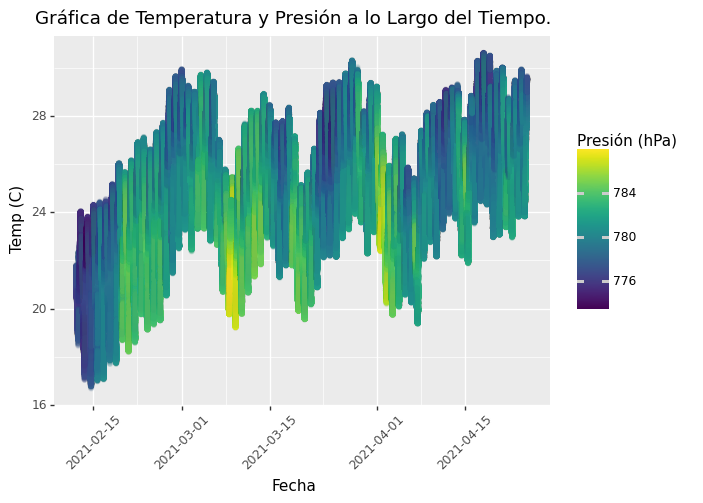

In [5]:
_ = (
    ggplot(df, aes(x = "datetime", y = "temperature", color="pressure")) +
    geom_jitter(alpha=0.05) +
    theme(axis_text_x=element_text(angle=45)) +
    labs(x="Fecha", y="Temp (C)", color="Presión (hPa)", 
         title="Gráfica de Temperatura y Presión a lo Largo del Tiempo.") 
).draw()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


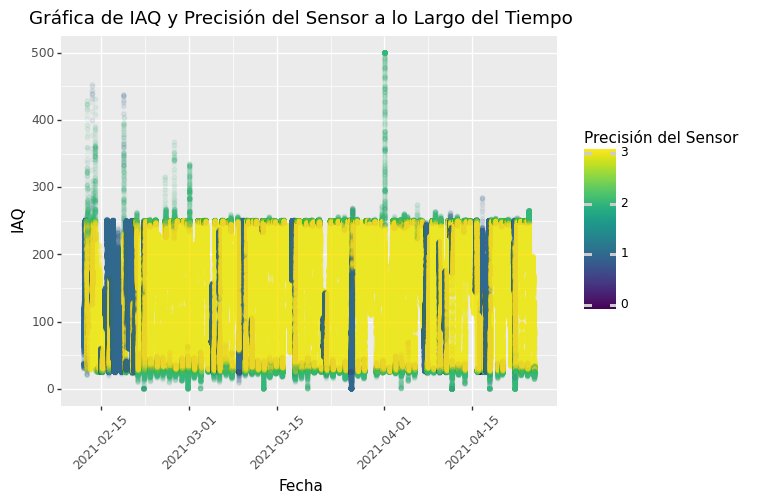

In [6]:
_ = (
    ggplot(df, aes(x = "datetime", y = "IAQ", color="iaqAccuracy")) +
    geom_jitter(alpha=0.05, size=1.25) +
    theme(axis_text_x=element_text(angle=45)) +
    labs(x="Fecha", color="Precisión del Sensor",
         title="Gráfica de IAQ y Precisión del Sensor a lo Largo del Tiempo")
).draw()

## Modelo

Proponemos utilizar un modelo de aprendizaje profundo con distintos tipos de neuronas artificiales:

* RNN: red neuronal recurrente.

* CNN: red neuronal convolucional.

* DNN: red neuronal densa.

Además de utilizar técnicas de series de tiempo, estadística frecuentista y bayesiana para el análisis de los datos.

### RNN

In [7]:
import io, os, time, re
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import \
    RMSprop, Adam, SGD
from tqdm.keras import TqdmCallback
import six

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Split and Scaling
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
#X = df_train.loc[:, useful_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(df_train.drop('datetime',axis=1))
X_test = min_max_scaler.transform(df_test.drop('datetime',axis=1))

In [10]:
def build_dataset(X, Y, hist_size):
    '''
    Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
    Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
    '''
    n_samples = Y.shape[0] - hist_size
    x = np.zeros((n_samples, hist_size, X.shape[1]))
    y = np.zeros((n_samples))

    for ind in range(n_samples):    
        x[ind] = X[ind : ind + hist_size]
        y[ind] = Y[ind + hist_size]
    return x, y

time_steps = 4
x_train, y_train = build_dataset(X=X_train, 
                                 Y=X_train[:,-4], 
                                 hist_size=time_steps)
x_test,  y_test  = build_dataset(X=X_test,  
                                 Y=X_test[:,-4],  
                                 hist_size=time_steps)

In [11]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=256))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               67584     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 67,841
Trainable params: 67,841
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile
rnn_model.compile(loss='mse', optimizer='rmsprop')

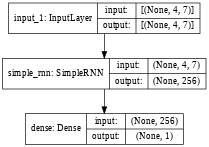

In [13]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(rnn_model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [14]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
A, B, C = rnn_model.layers[0].get_weights()
print(A.shape)
print(B.shape)
print(C.shape)

# == Q2 == 
# Renombra los ndarrays A, B, C, usando la notación vista en clase: Wh, Wx, b.

(7, 256)
(256, 256)
(256,)


In [15]:
# Weights in the second layer (FullyConnected)
W, b = rnn_model.layers[1].get_weights()
print(W.shape)
print(b.shape)

(256, 1)
(1,)


In [16]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
5817/5817 [==============================] - 31s 5ms/step - loss: 0.0013 - val_loss: 3.2183e-04
Epoch 2/10
5817/5817 [==============================] - 30s 5ms/step - loss: 6.2274e-05 - val_loss: 1.5729e-05
Epoch 3/10
5817/5817 [==============================] - 30s 5ms/step - loss: 3.8654e-05 - val_loss: 8.5270e-05
Epoch 4/10
5817/5817 [==============================] - 31s 5ms/step - loss: 2.9435e-05 - val_loss: 1.0645e-04
Epoch 5/10
5817/5817 [==============================] - 30s 5ms/step - loss: 2.4079e-05 - val_loss: 3.1884e-05
Epoch 6/10
5817/5817 [==============================] - 30s 5ms/step - loss: 2.0656e-05 - val_loss: 1.6530e-04
Epoch 7/10
5817/5817 [==============================] - 31s 5ms/step - loss: 1.8635e-05 - val_loss: 2.0346e-05
Epoch 8/10
5817/5817 [==============================] - 33s 6ms/step - loss: 1.6699e-05 - val_loss: 1.6969e-05
Epoch 9/10
5817/5817 [==============================] - 31s 5ms/step - loss: 1.5233e-05 - val_loss: 8.0501e-06
Epoch

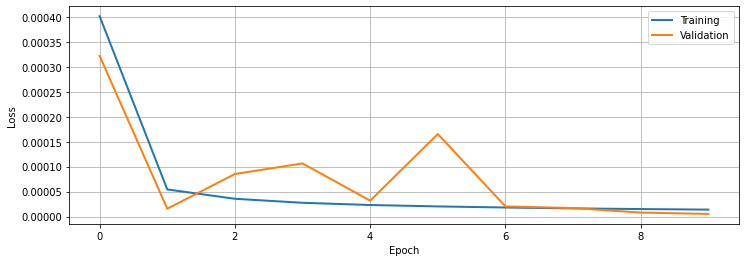

In [17]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [18]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(1654529, 1)
(413630, 1)


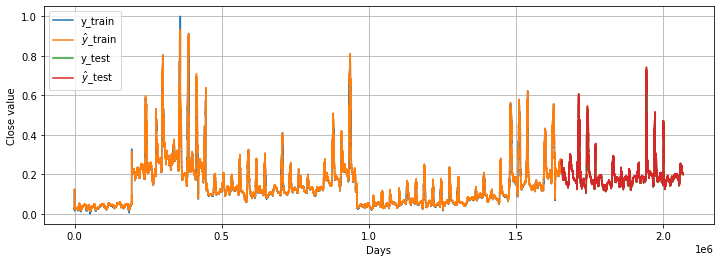

In [20]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train)
plt.plot(x_ticks[:len(y_train)], y_train_hat)
plt.plot(x_ticks[len(y_train):], y_test)
plt.plot(x_ticks[len(y_train):], y_test_hat)
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

# Trabajos relacionados

Hemos realizado algunos trabajos previos (1) y buscado artículos relacionados que describimos a continuación:

1. Examen final para la materia de "Modelos de Gran Escala" con la Prof. Liliana Millán, donde se estudiaron la relación de las estaciones de biciletas "Ecobici" con la calidad del aire en las inmediaciones.

2. Development of indoor environmental index: Air quality index and thermal comfort index. Referido en la bibliografía.


# Solución

Expondremos la relación que existe, si es que la hay, entre la calidad del aire exterior y la de una casa habitación. Así como el poder predictivo con métricas de su precisión ("accuracy"). En cuyo caso podríamos dar pie a que esta investigación termine en un Producto de Datos.

# Conclusiones

Buscaremos explicar nuestras conclusiones del análisis de:

* Análisis  exploratorios sobre los datos.

* Nuestras hipótesis y sus resultados.

* Nuestras pruebas con modelos de redes neuronales profundas y el procesamiento de señales.

* Los inconvenientes que encontramos y la influencia que ejercieron sobre el presente proyecto.

* Aprendizajes obtenidos durante el presente.

# Bibliografía

* [Bosch BME680 Datasheet](https://www.bosch-sensortec.com/media/boschsensortec/downloads/datasheets/bst-bme680-ds001.pdf). 2021.

* Mancuso, D. [Indoor Air Quality Monitor | Hackster.io](https://www.hackster.io/damancuso/indoor-air-quality-monitor-b181e9). 2019.

* [Dirección de Monitoreo Atmosféerico de la Secretaría del Medio Ambiente del Gobierno de la Ciudad de México](http://www.aire.cdmx.gob.mx/).

* [Sistema Nacional de Información de la Calidad del Aire del Gobierno Federal México](https://sinaica.inecc.gob.mx/).

*  Saad1 S. M., et al. Development of indoor environmental index: Air quality index and thermal comfort index [DOI: 10.1063/1.4975276](https://doi.org/10.1063/1.4975276). 2017.